Let's work on the Store Sales TS forecasting Kaggle competition. 


Store Sales - Time Series Forecasting¶
Before reading the notebook, what will you learn from this notebook?

Interpolation for Oil Prices
Detailed Data Manipulation for Holiday and Events Data
Exploratory Data Analysis
Hypothesis Testing
Modelling
This competition is about time series forcasting for store sales. The data comes from an Ecuador company as known as Corporación Favorita and it is a large grocery retailer. Also, the company operates in other countries in South America.

There are 54 stores and 33 prodcut families in the data. The time serie starts from 2013-01-01 and finishes in 2017-08-31. However, you know that Kaggle gives us splitted two data as train and test. The dates in the test data are for the 15 days after the last date in the training data. Date range in the test data will be very important to us while we are defining a cross-validation strategy and creating new features.

Our main mission in this competition is, predicting sales for each product family and store combinations.



There are 6 data that we will study on them step by step.

Train
Test
Store
Transactions
Holidays and Events
Daily Oil Price
The train data contains time series of the stores and the product families combination. The sales column gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).The onpromotion column gives the total number of items in a product family that were being promoted at a store at a given date.

Stores data gives some information about stores such as city, state, type, cluster.

Transaction data is highly correlated with train's sales column. You can understand the sales patterns of the stores.

Holidays and events data is a meta data. This data is quite valuable to understand past sales, trend and seasonality components. However, it needs to be arranged. You are going to find a comprehensive data manipulation for this data. That part will be one of the most important chapter in this notebook.

Daily Oil Price data is another data which will help us. Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. That's why, it will help us to understand which product families affected in positive or negative way by oil price.

When you look at the data description, you will see "Additional Notes". These notes may be significant to catch some patterns or anomalies. I'm sharing them with you to remember.
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# 1/ Imports

In [2]:

# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
print(os.getcwd())


/workspaces/Data_Science/Projects/Temporal_Series/Store_Sales_Forecast/notebooks


In [13]:
# 2/ Read Data

hl_events_df = pd.read_csv("../data/raw/holidays_events.csv")
#hl_events.head()
oil_df = pd.read_csv("../data/raw/oil.csv")
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")
stores_df = pd.read_csv("../data/raw/stores.csv")
transactions_df = pd.read_csv("../data/raw/transactions.csv")


In [14]:
# 3/ Adapt types
hl_events_df["date"] = pd.to_datetime(hl_events_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
hl_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [15]:
hl_events_df.head()
# 350 rows
# each row for a day of holiday, associated to a region (national or local)
hl_events_df.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [16]:
stores_df.head()
# 54 rows
# 1 row/store + city associated + type
stores_df.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [17]:
train_df.head(10000)
#train_df.info()
# 3 M rows
# 1 row/store/family product ?
#from 2013-01-01 to 2017-08-15

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0
...,...,...,...,...,...,...
9995,9995,2013-01-06,39,PREPARED FOODS,47.00,0
9996,9996,2013-01-06,39,PRODUCE,0.00,0
9997,9997,2013-01-06,39,SCHOOL AND OFFICE SUPPLIES,0.00,0
9998,9998,2013-01-06,39,SEAFOOD,19.54,0


In [18]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [19]:
oil_df.head()
# 1218 rows of oil price, 1row/day
#oil_df.info() 

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
transactions_df.head(10)
# 1 row/store/day 
# 83k rows
#transactions_df.info() 

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


# Questions 
- How to merge these datasets? 
- How to work on the data to get the good granularity?
- What vizu to build to get more insights?
- Transactions gives global transaction per store per day when train gives one degree of granularity furthers, providing also the product family => How to link both?

In [49]:
train_df.head()

sales_df = pd.DataFrame(train_df.groupby(["date", "store_nbr"]).sales.sum()).reset_index()
# rappelons que groupby() et sum() vont transformer les colonnes de group en index (donc multi index ici)
# ilfaut donc utiliser le reset_index pour s'en prémunir.
type(sales_df)#df
sales_df.head()

sales_df.info() # 91k rows
# transactions_df.head()
transactions_df.info() # 83K rows

sales_vs_transact_df = pd.merge(sales_df, transactions_df, how="left", on = ["date", "store_nbr"])
sales_vs_transact_df





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90936 entries, 0 to 90935
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       90936 non-null  datetime64[ns]
 1   store_nbr  90936 non-null  int64         
 2   sales      90936 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,sales,transactions
0,2013-01-01,1,0.000000,NaN
1,2013-01-01,2,0.000000,NaN
2,2013-01-01,3,0.000000,NaN
3,2013-01-01,4,0.000000,NaN
4,2013-01-01,5,0.000000,NaN
...,...,...,...,...
90931,2017-08-15,50,16879.121004,2804.0
90932,2017-08-15,51,20154.559000,1573.0
90933,2017-08-15,52,18600.046000,2255.0
90934,2017-08-15,53,8208.189000,932.0


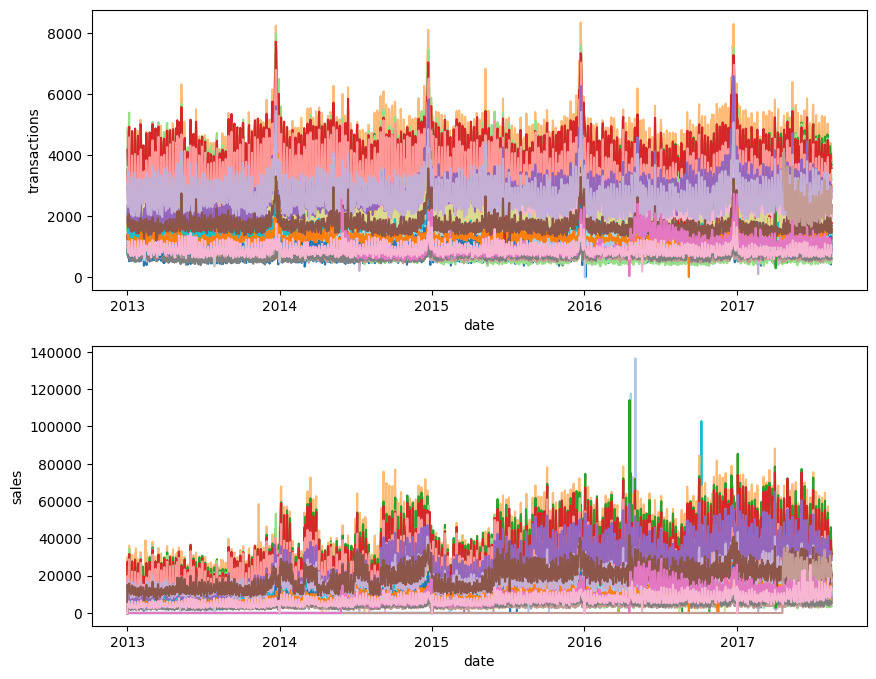

In [ ]:
# OK now let's plot 
# let's color by store

# Make one plot
# plt.figure(figsize = (10,8))
# # sns.scatterplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]), x = "date", y="transactions", hue = "store_nbr", palette = "tab20" )
# sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]), x = "date", y="transactions", hue = "store_nbr", palette = "tab20" )
# plt.legend([], [], frameon=False)  #supprime la légende
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.tight_layout()
# plt.show()
# #bbox_to_anchor=(1.05, 1) place la légende à droite, juste à l'extérieur du plot.


# lineplot plus visible et préférables pour ce genre ed données temporelles régulieres


fig, axes = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,8))

sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]),
            x = "date",
            y="transactions",
            hue = "store_nbr", 
            palette = "tab20",
            ax=axes[0] )
axes[0].legend([], [], frameon=False)

sns.lineplot(sales_vs_transact_df.sort_values(["store_nbr", "date"]),
            x = "date",
            y="sales",
            hue = "store_nbr", 
            palette = "tab20",
            ax=axes[1] )
axes[1].legend([], [], frameon=False)
plt.show()




In [ ]:
# let's compute the correlation between transactions and sales

sales_vs_transact_df["transactions"].corr(sales_vs_transact_df["sales"], method="pearson")
# 0.837 very high correlation


np.float64(0.8373836801431711)